<a href="https://colab.research.google.com/github/godfather-is-me/MNIST-DigitRecogniser/blob/main/MNIST_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Reads

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split

In [10]:
# Train and test values
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


## Visualize the data

In [17]:
def visual_random():
  index = np.random.randint(0, 42000)
  img = np.array(train.drop('label', axis=1).iloc[index])
  label = train.iloc[index]['label']

  plt.imshow(img.reshape(28, 28), cmap='gray')
  plt.title(label)
  plt.axis('off')

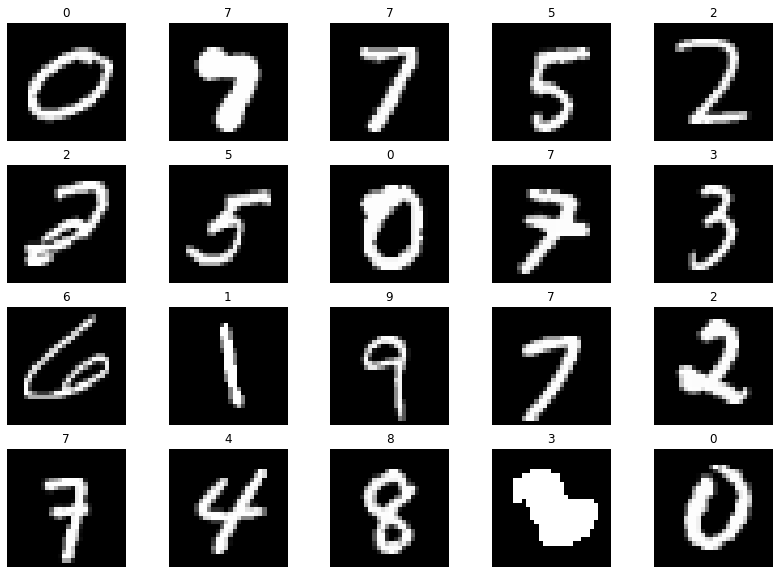

In [19]:
plt.figure(figsize=(14, 10))
for i in range(20):
  ax = plt.subplot(4, 5, i + 1)
  visual_random()

## Implementing morphological methods on data

### Train/test split

In [22]:
X = train.drop('label', axis = 1).values
y = train['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

### Creating a pipeline on a subset of the data

1. Original image
2. Upscaled image (x4)
3. Binarise image
4. Closing of the image
5. Downscaling the image

In [52]:
# %%time

pipe_subset = X_train.astype('uint8')[:7].copy()

## Kernel for closing
kernel = np.ones(shape=(6,6), dtype=np.uint8)

## Resize dimensions
original = 28
width = original * 4
height = original * 4

for i, img in enumerate(pipe_subset):
  img = ((cv2.resize(img, (height, width)) > 127) * 255).astype('uint8')
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1).astype('uint8')
  img = cv2.resize(img, (original, original))
  pipe_subset = np.concatenate((pipe_subset, np.expand_dims(img, axis=0)), axis=0)


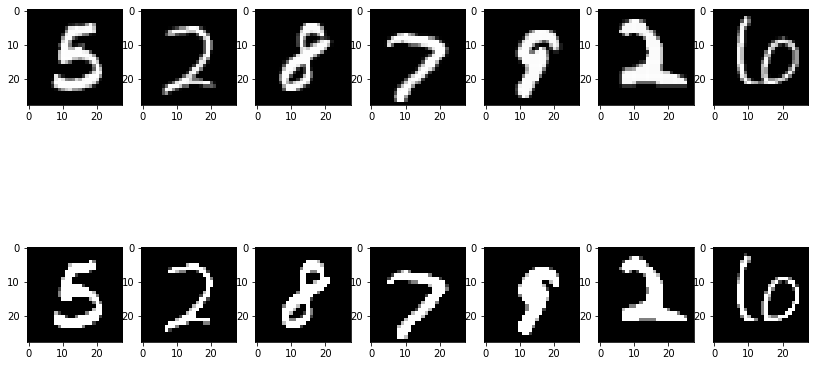

In [53]:
plt.figure(figsize=(14, 8))
for i in range(len(pipe_subset)):
  plt.subplot(2, 7, i + 1)
  plt.imshow(pipe_subset[i], cmap='gray')

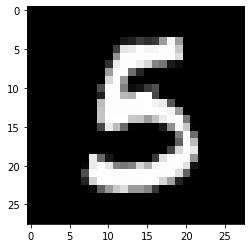

In [28]:
plt.imshow(X_train[0], cmap='gray')

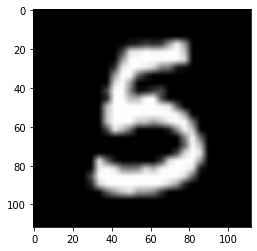

In [29]:
plt.imshow(cv2.resize(X_train[0].astype('uint8'), (112, 112)), cmap='gray')

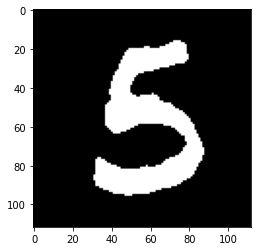

In [35]:
upscale_test = (cv2.resize(X_train[0].astype('uint8'), (112, 112)) > 127) * 255
plt.imshow(upscale_test, cmap='gray')

In [37]:
upscale_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
kernel_test = np.ones(shape=(7,7), dtype=np.uint8)
close_upscale_test = cv2.morphologyEx(upscale_test.astype('uint8'), cv2.MORPH_CLOSE, kernel_test, iterations=1)

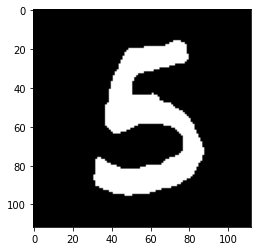

In [40]:
plt.imshow(close_upscale_test, cmap='gray')

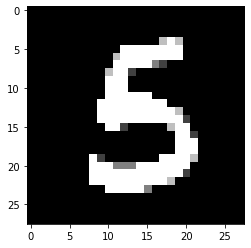

In [41]:
plt.imshow(cv2.resize(close_upscale_test.astype('uint8'), (28, 28)), cmap='gray')

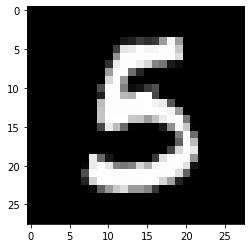

In [42]:
plt.imshow(X_train[0], cmap='gray')

### Pipeline

In [80]:
def pipeline(data):
  data = data.astype('uint8')
  

  ## Kernel for closing
  kernel = np.ones(shape=(7,7), dtype=np.uint8)

  ## Resize dimensions
  original = 28
  width = original * 4
  height = original * 4

  return_data = np.zeros((1, original, original))

  for img in data:
    img = ((cv2.resize(img, (height, width)) > 127) * 255).astype('uint8')
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1).astype('uint8')
    img = cv2.resize(img, (original, original))
    # pipe_subset = np.concatenate((pipe_subset, np.expand_dims(img, axis=0)), axis=0)
    
    # Data not expanded by dimensoion
    # Same y_train to be used as original
    return_data = np.concatenate((return_data, np.expand_dims(img, axis=0)), axis=0)

  return return_data[1:]

In [85]:
X_train_pipelined = pipeline(X_train)

In [64]:
X_train.shape

(33600, 28, 28)

In [86]:
X_train_pipelined.shape

(33600, 28, 28)

In [66]:
X_train_pipelined

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
np.save('X_train_pipelined.npy', X_train_pipelined)

In [92]:
abc = np.load('X_train_pipelined.npy')
abc

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [94]:
(X_train_pipelined == abc).all()

True

### Build model

In [87]:
model = keras.Sequential()

model.add(Conv2D(64, (4, 4), input_shape=(28, 28, 1)))